In [97]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import statsmodels.api as sm
from scipy import stats
from scipy.stats import boxcox
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RepeatedKFold, cross_validate
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras import layers

/var/folders/3k/lvpqmh5177qgn5zhmr71bjnm0000gn/T/ipykernel_2906/4073055180.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


# Data Cleaning (KaggleMovies.csv)

df is going to have all of our data about each movies

In [56]:
# Read the dataset
df = pd.read_csv('Datasets/KaggleMovies.csv')
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.precision', 2)
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.400000,927000.000000,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.000000,46998772.000000,Warner Bros.,146.000000
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.800000,65000.000000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.000000,58853106.000000,Columbia Pictures,104.000000
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.700000,1200000.000000,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.000000,538375067.000000,Lucasfilm,124.000000
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.700000,221000.000000,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.000000,83453539.000000,Paramount Pictures,88.000000
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.300000,108000.000000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.000000,39846344.000000,Orion Pictures,98.000000


In [57]:
# Renaming columns
column_mapping = {
    'name' : 'Name',
    'rating' : 'Rating',
    'genre' : 'Genre',
    'year' : 'Year',
    'released' : 'Released',
    'score' : 'Score',
    'votes' : 'Votes',
    'director' : 'Director',
    'writer' : 'Writer',
    'star' : 'Star',
    'country' : 'Country',
    'budget' : 'Budget',
    'gross' : 'Gross Revenue',
    'company' : 'Company',
    'runtime' : 'Runtime'
}

df = df.rename(columns=column_mapping)

In [58]:
# Check for empty spaces
print(f"Shape: {df.shape}\n")
isna = df.isna().sum(axis=0)
isna

Shape: (7668, 15)



Name                0
Rating             77
Genre               0
Year                0
Released            2
Score               3
Votes               3
Director            0
Writer              3
Star                1
Country             3
Budget           2171
Gross Revenue     189
Company            17
Runtime             4
dtype: int64

In [59]:
# Remove rows with null values
df = df.dropna()
print(f"Shape: {df.shape}\n")
print(df.isna().sum(axis=0))

Shape: (5421, 15)

Name             0
Rating           0
Genre            0
Year             0
Released         0
Score            0
Votes            0
Director         0
Writer           0
Star             0
Country          0
Budget           0
Gross Revenue    0
Company          0
Runtime          0
dtype: int64


In [60]:
# Convert certain columns to appropiate data types
df.loc[:,['Votes', 'Budget', 'Runtime', 'Gross Revenue']] = df[['Votes', 'Budget', 'Runtime', 'Gross Revenue']].astype('int')
df.loc[:,'Score'] = df['Score'].apply(lambda x: float("{:.2f}".format(x)))
df.head()

,Name,Rating,Genre,Year,Released,Score,Votes,Director,Writer,Star,Country,Budget,Gross Revenue,Company,Runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.400000,927000.000000,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.000000,46998772.000000,Warner Bros.,146.000000
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.800000,65000.000000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.000000,58853106.000000,Columbia Pictures,104.000000
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.700000,1200000.000000,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.000000,538375067.000000,Lucasfilm,124.000000
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.700000,221000.000000,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.000000,83453539.000000,Paramount Pictures,88.000000
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.300000,108000.000000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.000000,39846344.000000,Orion Pictures,98.000000


In [61]:
print(df.dtypes)

Name              object
Rating            object
Genre             object
Year               int64
Released          object
Score            float64
Votes            float64
Director          object
Writer            object
Star              object
Country           object
Budget           float64
Gross Revenue    float64
Company           object
Runtime          float64
dtype: object


In [62]:
# Check number of unique movie names
len(df['Name'].unique())

5336

In [63]:
#Drop duplicate movie names
df = df.drop_duplicates(subset=['Name'], keep='first')
print(f"Shape: {df.shape}\n")
df.head()

Shape: (5336, 15)



,Name,Rating,Genre,Year,Released,Score,Votes,Director,Writer,Star,Country,Budget,Gross Revenue,Company,Runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.400000,927000.000000,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.000000,46998772.000000,Warner Bros.,146.000000
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.800000,65000.000000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.000000,58853106.000000,Columbia Pictures,104.000000
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.700000,1200000.000000,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.000000,538375067.000000,Lucasfilm,124.000000
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.700000,221000.000000,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.000000,83453539.000000,Paramount Pictures,88.000000
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.300000,108000.000000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.000000,39846344.000000,Orion Pictures,98.000000


df now contains movies that are unique and have no empty values on any of its attributes

### Univariate Analysis (Numerical Variables)

In [64]:
df.describe()

,Year,Score,Votes,Budget,Gross Revenue,Runtime
count,5336.000000,5336.000000,5336.000000,5336.000000,5336.000000,5336.000000
mean,2001.507309,6.395184,114229.701274,35649050.434595,101592426.155922,108.087706
std,10.521542,0.962801,183538.251077,41241714.683371,184167193.593346,18.110382
min,1980.000000,1.900000,195.000000,6000.000000,309.000000,63.000000
25%,1993.000000,5.800000,19000.000000,10000000.000000,10622833.750000,95.000000
50%,2002.000000,6.500000,52000.000000,21000000.000000,35927567.000000,105.000000
75%,2010.000000,7.100000,128000.000000,45000000.000000,110353970.000000,118.000000
max,2020.000000,9.300000,2400000.000000,356000000.000000,2847246203.000000,271.000000


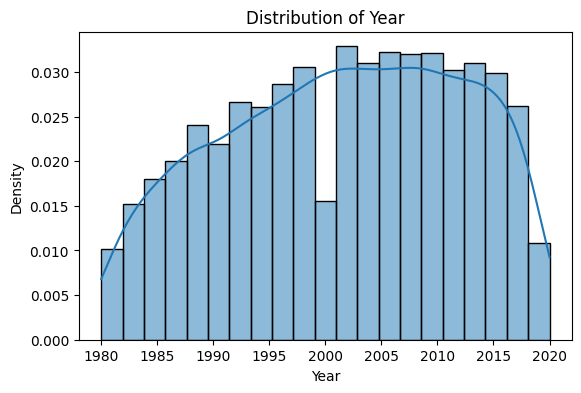

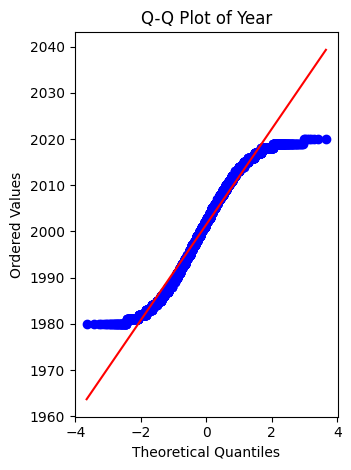

In [65]:
#Univariate Analysis of Year
plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Year'], kde=True, stat='density')
plt.title('Distribution of Year')
plt.xlabel('Year')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Year'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Year')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()

plt.show()

Here is our graphs representing the univariate analysis of 'Year'

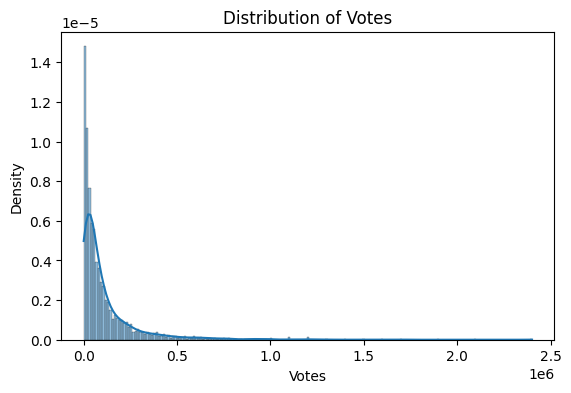

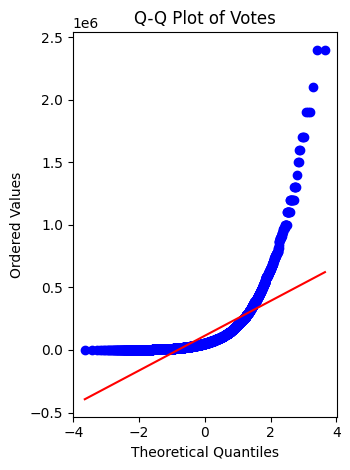

In [66]:
#Univariate Analysis of Votes
plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Votes'], kde=True, stat='density')
plt.title('Distribution of Votes')
plt.xlabel('Votes')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Votes'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Votes')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

Here is our graphs representing the univariate analysis of 'Votes'

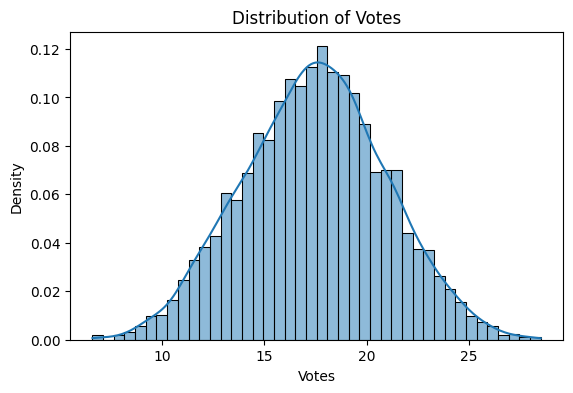

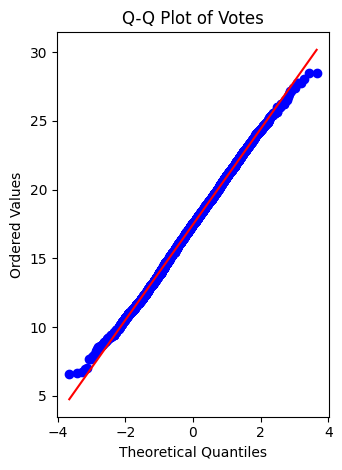

In [67]:
#Normalize the right skewed data
df['Votes'], lambda_votes = boxcox(df['Votes'])

plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Votes'], kde=True, stat='density')
plt.title('Distribution of Votes')
plt.xlabel('Votes')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Votes'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Votes')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

Here is our graphs representing the univariate analysis of 'Votes' after normalizing our data

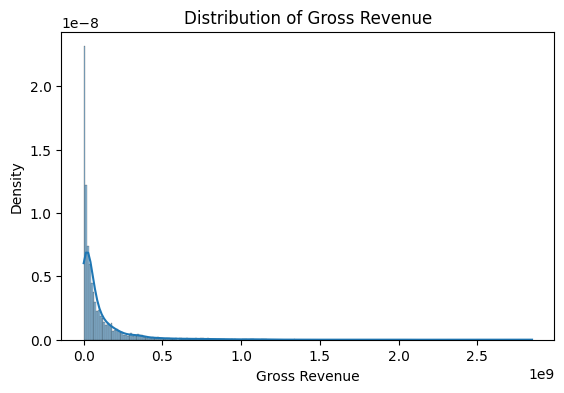

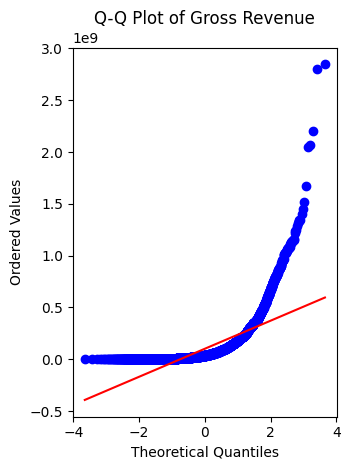

In [68]:
#Univariate Analysis of Gross Revenue
plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Gross Revenue'], kde=True, stat='density')
plt.title('Distribution of Gross Revenue')
plt.xlabel('Gross Revenue')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Gross Revenue'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Gross Revenue')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

Here is our graphs representing the univariate analysis of 'Gross Revenue'

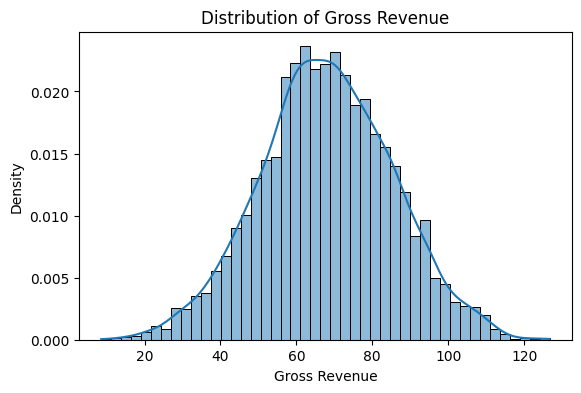

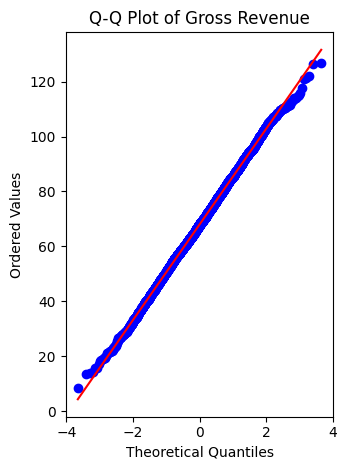

In [69]:
#Normalize the right skewed data
df['Gross Revenue'], lambda_gross = boxcox(df['Gross Revenue'])
plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Gross Revenue'], kde=True, stat='density')
plt.title('Distribution of Gross Revenue')
plt.xlabel('Gross Revenue')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Gross Revenue'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Gross Revenue')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

Here is our graphs representing the univariate analysis of 'Gross Revenue' after normalizing it

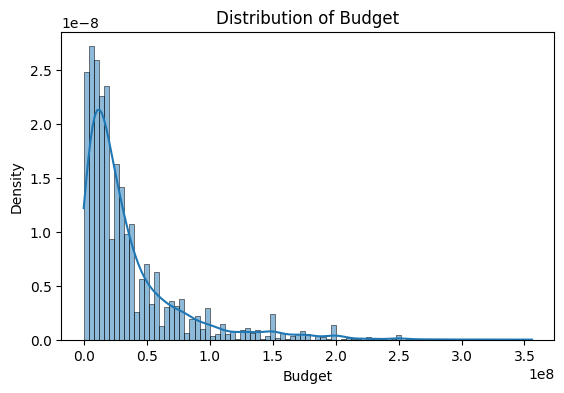

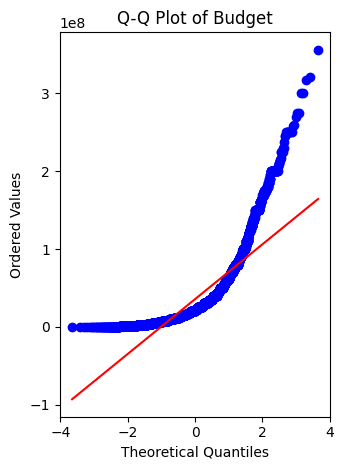

In [70]:
#Univariate Analysis of Budget
plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Budget'], kde=True, stat='density')
plt.title('Distribution of Budget')
plt.xlabel('Budget')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Budget'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Budget')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

Here is our graphs representing the univariate analysis of 'Budget'

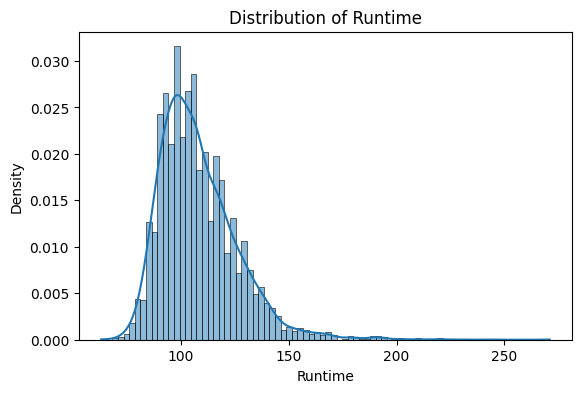

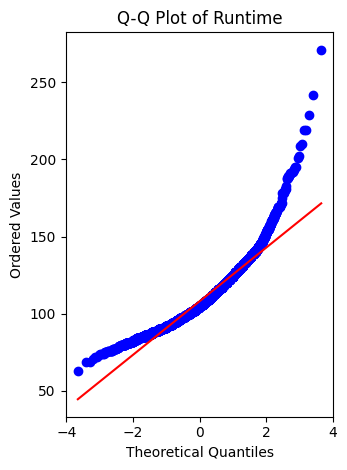

In [71]:
#Univariate Analysis of Runtime
plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Runtime'], kde=True, stat='density')
plt.title('Distribution of Runtime')
plt.xlabel('Runtime')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Runtime'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Runtime')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

Here is our graphs representing the univariate analysis of 'Runtime'

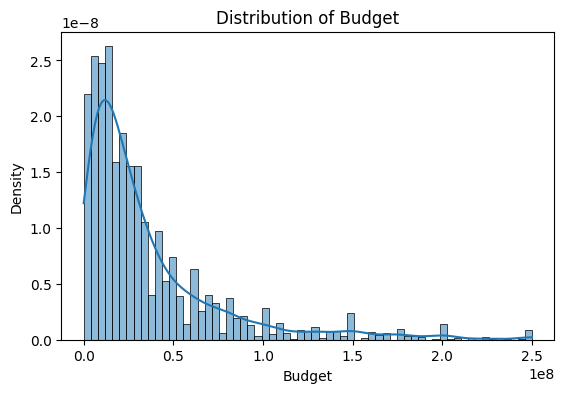

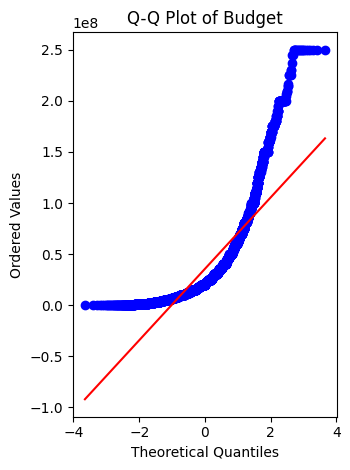

In [72]:
df['Budget'] = df['Budget'].apply(lambda x: 250000000 if x > 250000000 else x)

plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Budget'], kde=True, stat='density')
plt.title('Distribution of Budget')
plt.xlabel('Budget')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Budget'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Budget')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()


Here is our graphs representing the univariate analysis of 'Budget' after we cap the values above 250,000,000 to 250,000,000

### Univariate Analysis (Categorical Variables)

In [73]:
print("Unique Value Count of Categorical Variables")
print("Rating:", len(df['Rating'].unique()))
print("Genre:",len(df['Genre'].unique()))
print("Director:",len(df['Director'].unique()))
print("Writer:",len(df['Writer'].unique()))
print("Star:",len(df['Star'].unique()))
print("Country:",len(df['Country'].unique()))
print("Company:",len(df['Company'].unique()))

Unique Value Count of Categorical Variables
Rating: 10
Genre: 15
Director: 2045
Writer: 3178
Star: 1830
Country: 50
Company: 1464


Text(0.5, 1.0, 'Mean Score by Rating')

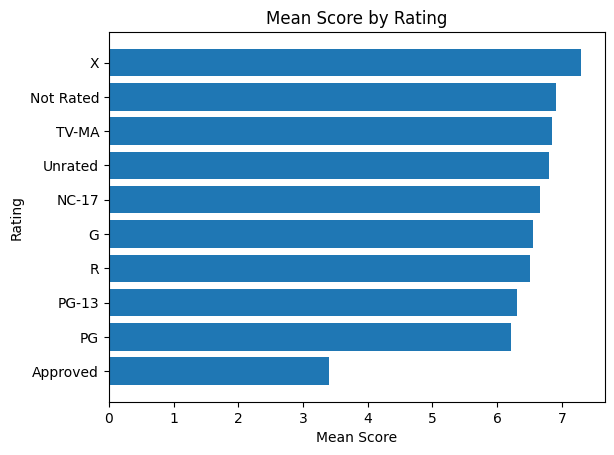

In [74]:
score_by_rating = df.groupby("Rating")["Score"].mean().sort_values(ascending=True)

plt.barh(score_by_rating.index, score_by_rating.values)
plt.xlabel('Mean Score')
plt.ylabel('Rating')
plt.title('Mean Score by Rating')

This horizontal bar chart displays the average scores for different content ratings of movies.

Text(0.5, 1.0, 'Mean Score by Genre')

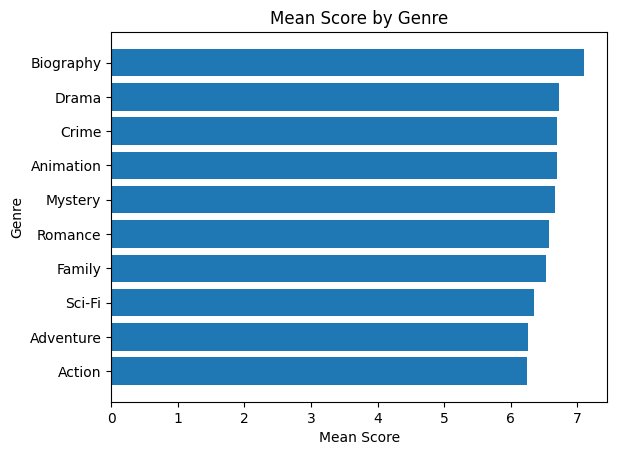

In [75]:
score_by_genre = df.groupby("Genre")["Score"].mean().sort_values(ascending=True)[len(df['Genre'].unique()) - 10 :]

plt.barh(score_by_genre.index, score_by_genre.values)
plt.xlabel('Mean Score')
plt.ylabel('Genre')
plt.title('Mean Score by Genre')

This horizontal bar chart displays the average scores for different movie genres.

Text(0.5, 1.0, 'Count by Genre')

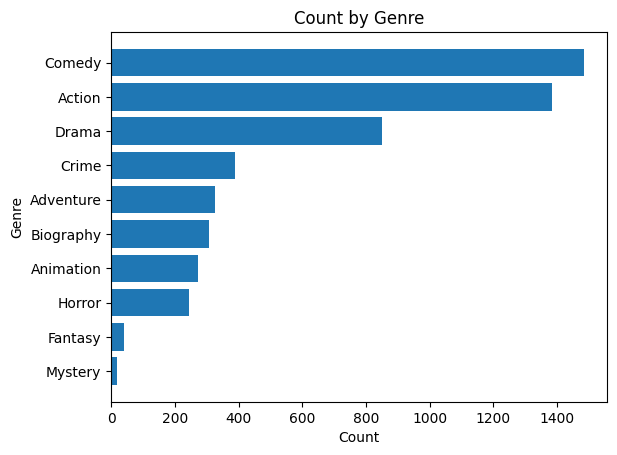

In [76]:
count_by_genre = df.groupby("Genre")["Score"].count().sort_values(ascending=True)[len(df['Genre'].unique()) - 10 :]

plt.barh(count_by_genre.index, count_by_genre.values)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Count by Genre')

The bar chart illustrates the distribution across various genres of movies.

Text(0.5, 1.0, 'Mean Score by Country')

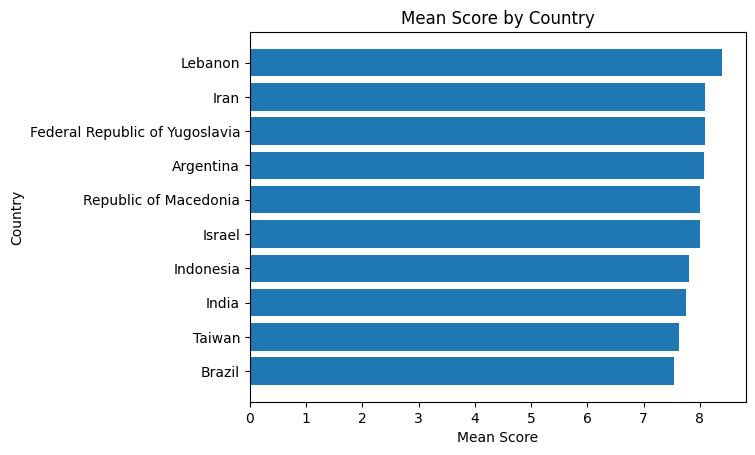

In [77]:
score_by_country = df.groupby("Country")["Score"].mean().sort_values(ascending=True)[len(df['Country'].unique()) - 10 :]

plt.barh(score_by_country.index, score_by_country.values)
plt.xlabel('Mean Score')
plt.ylabel('Country')
plt.title('Mean Score by Country')

This horizontal bar chart displays the average scores of movies released by various countries.

Text(0.5, 1.0, 'Count by Country')

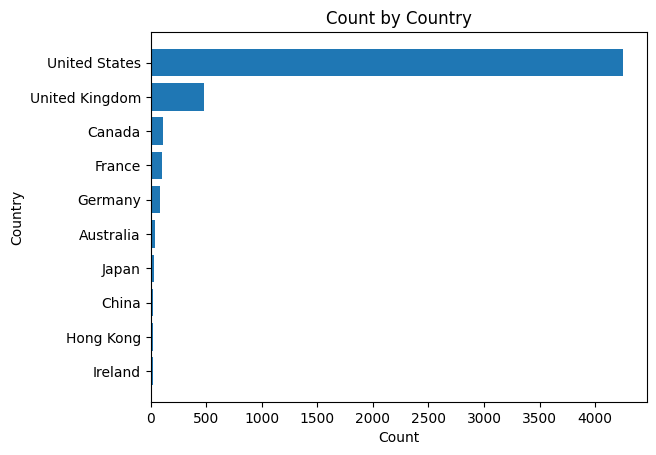

In [78]:
count_by_country = df.groupby("Country")["Score"].count().sort_values(ascending=True)[len(df['Country'].unique()) - 10 :]

plt.barh(count_by_country.index, count_by_country.values)
plt.xlabel('Count')
plt.ylabel('Country')
plt.title('Count by Country')

This horizontal bar chart displays the number of movies released by various countries.

Text(0.5, 1.0, 'Mean Score by Company')

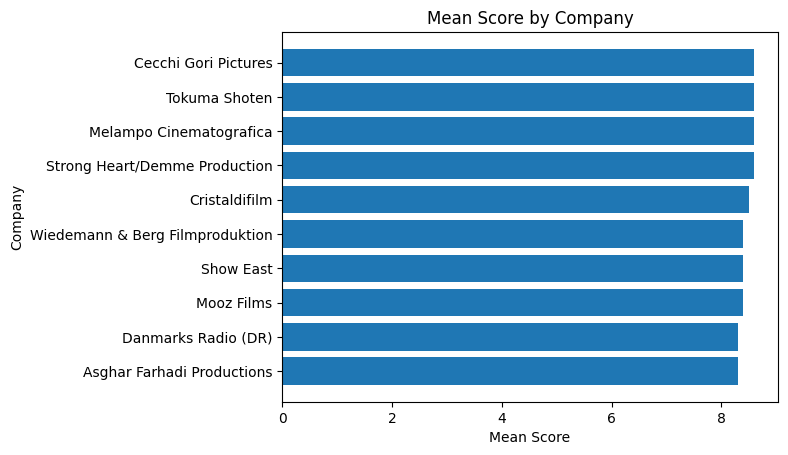

In [79]:
score_by_company = df.groupby("Company")["Score"].mean().sort_values(ascending=True)[len(df['Company'].unique()) - 10 :]

plt.barh(score_by_company.index, score_by_company.values)
plt.xlabel('Mean Score')
plt.ylabel('Company')
plt.title('Mean Score by Company')

This horizontal bar chart displays the average score released by various companies ordered from highest to lowest.

Text(0.5, 1.0, 'Mean Score by Company')

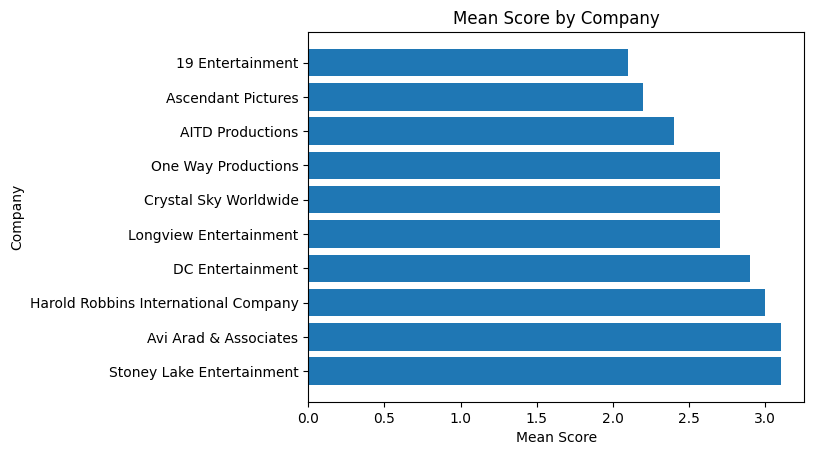

In [80]:
score_by_company = df.groupby("Company")["Score"].mean().sort_values(ascending=False)[len(df['Company'].unique()) - 10 :]

plt.barh(score_by_company.index, score_by_company.values)
plt.xlabel('Mean Score')
plt.ylabel('Company')
plt.title('Mean Score by Company')

This horizontal bar chart displays the average score released by various companies ordered in lowest to highest.

Text(0.5, 1.0, 'Count by Company')

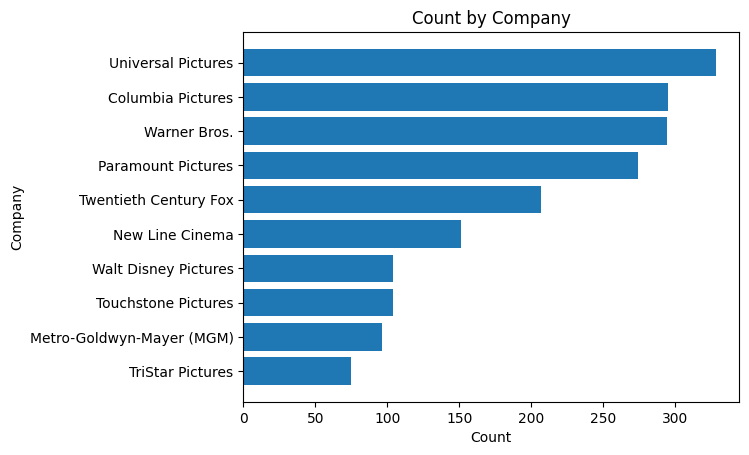

In [81]:
score_by_company = df.groupby("Company")["Score"].count().sort_values(ascending=True)[len(df['Company'].unique()) - 10 :]

plt.barh(score_by_company.index, score_by_company.values)
plt.xlabel('Count')
plt.ylabel('Company')
plt.title('Count by Company')

This horizontal bar chart displays the total count released by various companies.

### Data Transformation


In [82]:
# Instantiating MinMaxScaler and StandardScaler
scaler_minmax = MinMaxScaler()
scaler_std = StandardScaler()

# Scaling the columns
df[['Budget']] = scaler_minmax.fit_transform(df[['Budget']])
df[['Votes', 'Gross Revenue', 'Runtime']] = scaler_std.fit_transform(df[['Votes', 'Gross Revenue', 'Runtime']])

# Performing one-hot encoding on 'Rating', 'Genre', and 'Country' columns
oneHot = pd.get_dummies(df[['Rating', 'Genre', 'Country']], columns=['Rating', 'Genre', 'Country'])
df = pd.concat([df, oneHot], axis=1)
df.head()


,Name,Rating,Genre,Year,Released,Score,Votes,Director,Writer,Star,...,Country_Spain,Country_Sweden,Country_Switzerland,Country_Taiwan,Country_Thailand,Country_United Arab Emirates,Country_United Kingdom,Country_United States,Country_West Germany,Country_Yugoslavia
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.400000,2.294269,Stanley Kubrick,Stephen King,Jack Nicholson,...,False,False,False,False,False,False,True,False,False,False
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.800000,0.173770,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,...,False,False,False,False,False,False,False,True,False,False
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.700000,2.525956,Irvin Kershner,Leigh Brackett,Mark Hamill,...,False,False,False,False,False,False,False,True,False,False
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.700000,1.092990,Jim Abrahams,Jim Abrahams,Robert Hays,...,False,False,False,False,False,False,False,True,False,False
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.300000,0.543980,Harold Ramis,Brian Doyle-Murray,Chevy Chase,...,False,False,False,False,False,False,False,True,False,False


### Bivariate Analysis

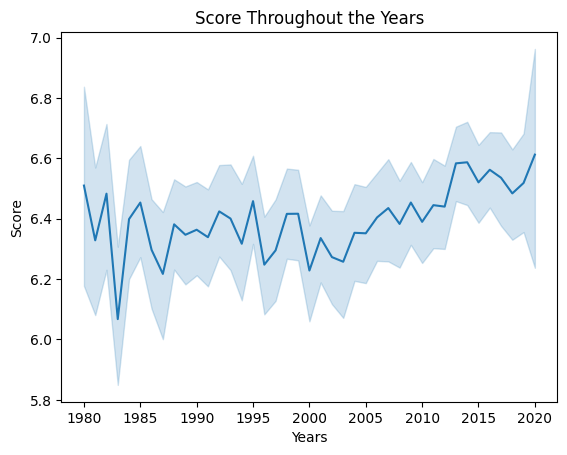

In [83]:
sns.lineplot(data=df, x="Year", y="Score")

plt.title('Score Throughout the Years')
plt.xlabel('Years')
plt.ylabel('Score')

# Show the plot
plt.show()

This is our graph representing the Bivariate analysis of 'Score' throughout the years

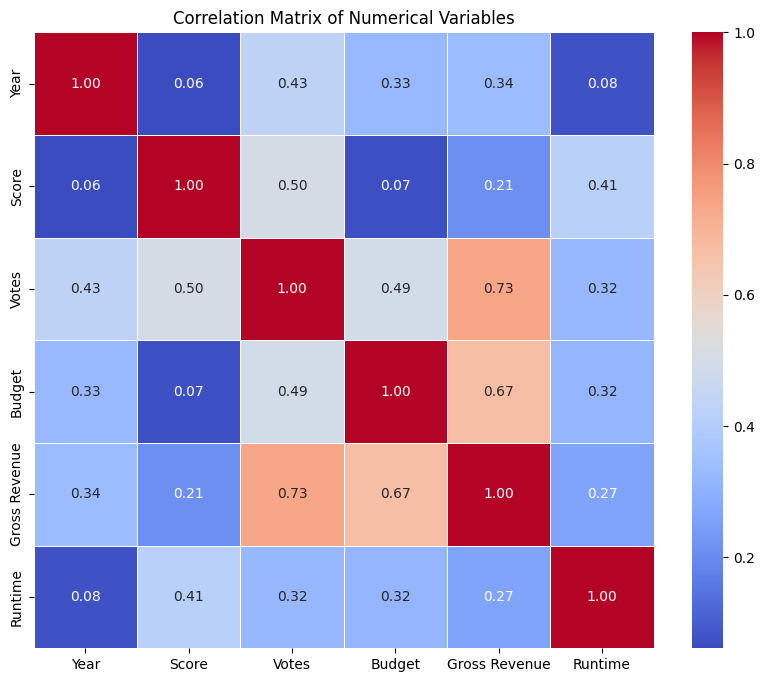

In [84]:
correlation_matrix = df[["Year", 'Score', "Votes", "Budget", "Gross Revenue", "Runtime"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

This is our correlation matrix of attributes that have numerical values

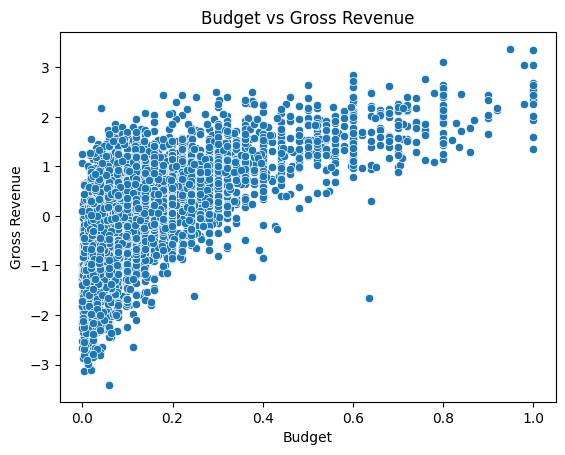

In [85]:
sns.scatterplot(data=df, x="Budget", y="Gross Revenue")

plt.title('Budget vs Gross Revenue')
plt.xlabel('Budget')
plt.ylabel('Gross Revenue')

plt.show()

This is our graph representing the Bivariate analysis of 'Budget' vs 'Gross Reveue'

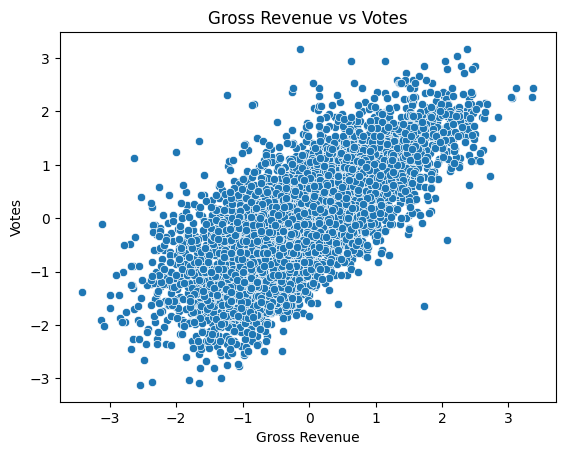

In [86]:
sns.scatterplot(data=df, x="Gross Revenue", y="Votes")

plt.title('Gross Revenue vs Votes')
plt.xlabel('Gross Revenue')
plt.ylabel('Votes')

plt.show()

This is our graph representing the Bivariate analysis of 'Gross Revenue' vs 'Votes'

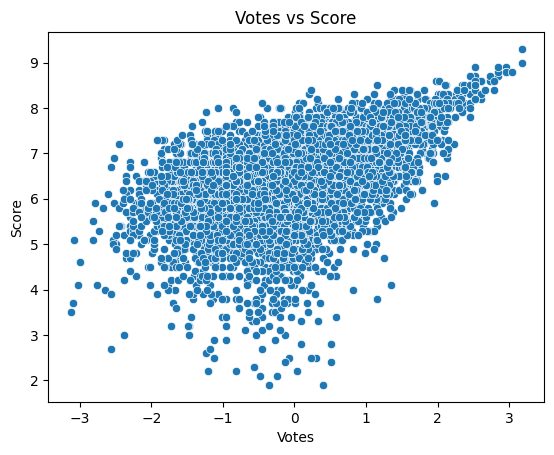

In [87]:
sns.scatterplot(data=df, x="Votes", y="Score")

plt.title('Votes vs Score')
plt.xlabel('Votes')
plt.ylabel('Score')

plt.show()

This is our graph representing the Bivariate analysis of 'Vote' vs 'Score'

# TRAINING MODEL

### Data Preprocessing

In [90]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Separate features and the target variable
# Assuming 'genre' as the target variable for this exercise
X_movies = df.drop('Genre', axis=1)
y_movies = df['Genre']

# Dropping non-numeric columns to simplify the input features for neural network training
X_movies_numeric = X_movies.select_dtypes(include=['float64', 'int64'])

# Apply one-hot encoding to the target variable (genre)
encoder_movies = OneHotEncoder()
y_movies_encoded = encoder_movies.fit_transform(y_movies.values.reshape(-1, 1)).toarray()

# Apply min-max normalization to the features
scaler_movies = MinMaxScaler()
X_movies_scaled = scaler_movies.fit_transform(X_movies_numeric)

# Now, X_movies_scaled and y_movies_encoded are ready for the neural network training process
df


,Name,Rating,Genre,Year,Released,Score,Votes,Director,Writer,Star,...,Country_Spain,Country_Sweden,Country_Switzerland,Country_Taiwan,Country_Thailand,Country_United Arab Emirates,Country_United Kingdom,Country_United States,Country_West Germany,Country_Yugoslavia
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.400000,2.294269,Stanley Kubrick,Stephen King,Jack Nicholson,...,False,False,False,False,False,False,True,False,False,False
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.800000,0.173770,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,...,False,False,False,False,False,False,False,True,False,False
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.700000,2.525956,Irvin Kershner,Leigh Brackett,Mark Hamill,...,False,False,False,False,False,False,False,True,False,False
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.700000,1.092990,Jim Abrahams,Jim Abrahams,Robert Hays,...,False,False,False,False,False,False,False,True,False,False
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.300000,0.543980,Harold Ramis,Brian Doyle-Murray,Chevy Chase,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7648,Bad Boys for Life,R,Action,2020,"January 17, 2020 (United States)",6.600000,0.739239,Adil El Arbi,Peter Craig,Will Smith,...,False,False,False,False,False,False,False,True,False,False
7649,Sonic the Hedgehog,PG,Action,2020,"February 14, 2020 (United States)",6.500000,0.501529,Jeff Fowler,Pat Casey,Ben Schwartz,...,False,False,False,False,False,False,False,True,False,False
7650,Dolittle,PG,Adventure,2020,"January 17, 2020 (United States)",5.600000,0.029252,Stephen Gaghan,Stephen Gaghan,Robert Downey Jr.,...,False,False,False,False,False,False,False,True,False,False
7651,The Call of the Wild,PG,Adventure,2020,"February 21, 2020 (United States)",6.800000,-0.132540,Chris Sanders,Michael Green,Harrison Ford,...,False,False,False,False,False,False,False,False,False,False


### Training and Testing the Neural Network (40 points)

In [91]:
# Split the data into training and testing sets with a 90:10 ratio
X_train, X_test, y_train, y_test = train_test_split(X_movies_scaled, y_movies_encoded, test_size=0.1, random_state=42)

# Define the model
model = Sequential([
    Dense(12, input_dim=X_train.shape[1], activation='sigmoid'),
    Dense(12, activation='sigmoid'),
    Dense(12, activation='sigmoid'),
    Dense(12, activation='sigmoid'),
    Dense(y_train.shape[1], activation='sigmoid')  # Number of output nodes = number of classes
])

# Compile the model with Stochastic Gradient Descent optimizer
optimizer = SGD(learning_rate=0.3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, verbose=1)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate metrics
cm = confusion_matrix(y_test_classes, y_pred_classes)
acc = accuracy_score(y_test_classes, y_pred_classes)
mse = mean_squared_error(y_test, y_pred)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_test_classes, y_pred_classes, average='weighted', zero_division=0)

# Output the metrics
print("Confusion Matrix:", cm)
print("Accuracy:", acc)
print("MSE:", mse)
print("Precision:", precision)
print("Recall:", recall)

Epoch 1/100
136/136 [==============================] - 2s 4ms/step - loss: 1.9795 - accuracy: 0.2650 - mse: 0.2834 - val_loss: 2.1998 - val_accuracy: 0.2536 - val_mse: 0.2999
Epoch 2/100
136/136 [==============================] - 0s 3ms/step - loss: 1.9253 - accuracy: 0.2701 - mse: 0.3218 - val_loss: 2.1484 - val_accuracy: 0.2536 - val_mse: 0.3196
Epoch 3/100
136/136 [==============================] - 0s 3ms/step - loss: 1.9181 - accuracy: 0.2682 - mse: 0.3327 - val_loss: 2.0082 - val_accuracy: 0.0561 - val_mse: 0.3413
Epoch 4/100
136/136 [==============================] - 1s 5ms/step - loss: 1.9204 - accuracy: 0.2712 - mse: 0.3396 - val_loss: 2.0401 - val_accuracy: 0.0790 - val_mse: 0.3418
Epoch 5/100
136/136 [==============================] - 0s 3ms/step - loss: 1.9184 - accuracy: 0.2715 - mse: 0.3423 - val_loss: 2.0997 - val_accuracy: 0.2536 - val_mse: 0.3370
Epoch 6/100
136/136 [==============================] - 1s 4ms/step - loss: 1.9172 - accuracy: 0.2668 - mse: 0.3450 - val_loss

### k-fold Cross Validation

In [96]:
# Function to build the model, adapted for the Kaggle movie dataset
def build_movie_model():
    model = Sequential([
        Dense(12, input_dim=X_movies_scaled.shape[1], activation='sigmoid'),
        Dense(12, activation='sigmoid'),
        Dense(12, activation='sigmoid'),
        Dense(y_movies_encoded.shape[1], activation='sigmoid')  # Output layer nodes = number of classes
    ])
    model.compile(optimizer=SGD(learning_rate=0.3), loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
    return model

# Wrap the Keras model with KerasClassifier
estimator_movies = KerasClassifier(model=build_movie_model, epochs=100, batch_size=10, verbose=1)  # Adjust verbosity as needed

# Define the cross-validation strategy
kfold_movies = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)

# Perform cross-validation for accuracy and MSE
results_movies = cross_validate(estimator_movies, X_movies_scaled, y_movies_encoded, cv=kfold_movies, scoring=['accuracy', 'neg_mean_squared_error'], n_jobs=1)

# Output results
print("Cross-validation results:")
print(results_movies)

Cross-validation results:
{'fit_time': array([79.02806711, 69.80233192, 71.01192403, 66.12080789, 61.574368  ,
       71.39393091, 74.65364408, 63.651371  , 60.03977609, 64.54023719]), 'score_time': array([0.25572515, 0.22907996, 0.2555511 , 0.27689505, 0.20048189,
       0.41673517, 0.23091316, 0.20589209, 0.20789409, 0.23333597]), 'test_accuracy': array([0.45505618, 0.37265918, 0.42696629, 0.43445693, 0.41198502,
       0.39325843, 0.42213884, 0.42213884, 0.42213884, 0.42964353]), 'test_neg_mean_squared_error': array([-0.07265918, -0.08364544, -0.07640449, -0.07540574, -0.078402  ,
       -0.08089888, -0.07704816, -0.07704816, -0.07704816, -0.07604753])}


In [99]:
# Assuming 'results_movies' contains the cross-validation results from the previous step
cv_accuracy_movies = results_movies['test_accuracy']
cv_mse_movies = -1 * results_movies['test_neg_mean_squared_error']  # Multiply by -1 to make MSE positive

# Print accuracy and MSE values for each fold
for i in range(len(cv_accuracy_movies)):
    print(f"Fold {i+1}: Accuracy = {cv_accuracy_movies[i]}, MSE = {cv_mse_movies[i]}")

# Print the overall average accuracy and MSE for the Kaggle movie dataset
print(f"Overall Average Accuracy: {np.mean(cv_accuracy_movies)}")
print(f"Overall Average MSE: {np.mean(cv_mse_movies)}")


Fold 1: Accuracy = 0.4550561797752809, MSE = 0.07265917602996255
Fold 2: Accuracy = 0.37265917602996257, MSE = 0.08364544319600498
Fold 3: Accuracy = 0.42696629213483145, MSE = 0.07640449438202244
Fold 4: Accuracy = 0.4344569288389513, MSE = 0.07540574282147314
Fold 5: Accuracy = 0.41198501872659177, MSE = 0.07840199750312109
Fold 6: Accuracy = 0.39325842696629215, MSE = 0.08089887640449435
Fold 7: Accuracy = 0.42213883677298314, MSE = 0.07704815509693558
Fold 8: Accuracy = 0.42213883677298314, MSE = 0.07704815509693558
Fold 9: Accuracy = 0.42213883677298314, MSE = 0.07704815509693559
Fold 10: Accuracy = 0.42964352720450283, MSE = 0.0760475297060663
Overall Average Accuracy: 0.41904420599953623
Overall Average MSE: 0.07746077253339517


### Hyperparameter Tuning

In [108]:
# Split the data
X_train_hp, X_test_hp, y_train_hp, y_test_hp = train_test_split(X_movies_scaled, y_movies_encoded, test_size=0.1, random_state=42)
def build_hp_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=12, max_value=512, step=100),
                    activation='sigmoid',
                    input_dim=X_train_hp.shape[1]))
    model.add(Dense(units=hp.Int('units_layer2', min_value=12, max_value=512, step=100), activation='sigmoid'))
    model.add(Dense(units=hp.Int('units_layer3', min_value=12, max_value=512, step=100), activation='sigmoid'))
    model.add(Dense(y_train_hp.shape[1], activation='sigmoid'))  # Adapted for multi-class classification

    # Tune the learning rate for the optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model.compile(optimizer=SGD(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model
# Define the tuner
# tuner = kt.Hyperband(
#     build_hp_model,
#     objective='val_accuracy',
#     max_epochs=10,
#     hyperband_iterations=2,
#     directory='tuner_results',
#     project_name='kaggle_movie_tuning'
# )

# Define the tuner
tuner = kt.GridSearch(
    hypermodel=build_hp_model,
    objective='val_mse',
    max_trials=10,
    executions_per_trial=3,
    seed=15,
    tune_new_entries=True,
    allow_new_entries=True,
    directory='tuner_results',
    project_name='keras_tuner_project'
)

# Run the hyperparameter search
tuner.search(X_train_hp, y_train_hp, epochs=50, validation_split=0.1)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

print(f"""
The optimal number of units in the first hidden layer is {best_hps.get('units')}
with an optimal learning rate of {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and evaluate it
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_hp, y_train_hp, epochs=50, validation_data=(X_test_hp, y_test_hp))

Reloading Tuner from tuner_results/keras_tuner_project/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
12                |12                |units
12                |12                |units_layer2
12                |12                |units_layer3
0.00031623        |0.00031623        |learning_rate

Epoch 1/50
136/136 [==============================] - 2s 6ms/step - loss: 2.8170 - accuracy: 0.0079 - val_loss: 2.8012 - val_accuracy: 0.0083
Epoch 2/50
136/136 [==============================] - 0s 3ms/step - loss: 2.7923 - accuracy: 0.0079 - val_loss: 2.7768 - val_accuracy: 0.0083
Epoch 3/50
136/136 [==============================] - 0s 4ms/step - loss: 2.7682 - accuracy: 0.0079 - val_loss: 2.7530 - val_accuracy: 0.0083
Epoch 4/50
136/136 [==============================] - 1s 5ms/step - loss: 2.7447 - accuracy: 0.0079 - val_loss: 2.7297 - val_accuracy: 0.0083
Epoch 5/50
136/136 [==============================] - 0s 4ms/step - loss: 2.7218 - acc

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras_tuner/src/engine/base_tuner.py", line 264, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/kera

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras_tuner/src/engine/base_tuner.py", line 264, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras_tuner/src/engine/tuner_utils.py", line 145, in convert_to_metrics_dict
    best_value, _ = _get_best_value_and_best_epoch_from_history(
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras_tuner/src/engine/tuner_utils.py", line 116, in _get_best_value_and_best_epoch_from_history
    objective_value = objective.get_value(metrics)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras_tuner/src/engine/objective.py", line 59, in get_value
    return logs[self.name]
KeyError: 'val_mse'
